In [1]:
import os
from glob import glob

dataset_folder = os.path.join(os.getenv('HOME'), 'datasets', 'CT')
normal = glob(os.path.join(dataset_folder, 'CT-0') + '/*.nii.gz')
abnormal = glob(os.path.join(dataset_folder, 'CT-23') + '/*.nii.gz')

print('normal images', len(normal))
print('abnormal images', len(abnormal))

normal images 100
abnormal images 100


In [2]:
## The files are provided in Nifti format with the extension .nii. To read the scans, we use the nibabel package.

import nibabel as nib


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


example_img = read_nifti_file(normal[0])
example_img.shape

(512, 512, 41)

In [3]:
import numpy as np
from scipy import ndimage


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


abnormal_scans = np.array([process_scan(path) for path in abnormal])
normal_scans = np.array([process_scan(path) for path in normal])

abnormal_labels = np.array([1 for _ in range(len(abnormal))])
normal_labels = np.array([0 for _ in range(len(normal))])

In [4]:
import torch

train_size = int(len(normal) * 0.8)

x_train = np.concatenate((abnormal_scans[:train_size], normal_scans[:train_size]), axis=0)
y_train = np.concatenate((abnormal_labels[:train_size], normal_labels[:train_size]), axis=0)
x_val = np.concatenate((abnormal_scans[train_size:], normal_scans[train_size:]), axis=0)
y_val = np.concatenate((abnormal_labels[train_size:], normal_labels[train_size:]), axis=0)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

x_train = torch.unsqueeze(x_train, -1)
x_train = torch.permute(x_train, (0, 4, 3, 1, 2))
y_train = torch.unsqueeze(y_train, -1)
x_val = torch.unsqueeze(x_val, -1)
x_val = torch.permute(x_val, (0, 4, 3, 1, 2))
y_val = torch.unsqueeze(y_val, -1)

print(f"Number of samples in train and validation are {x_train.shape} and {x_val.shape}")

Number of samples in train and validation are torch.Size([160, 1, 64, 128, 128]) and torch.Size([40, 1, 64, 128, 128])


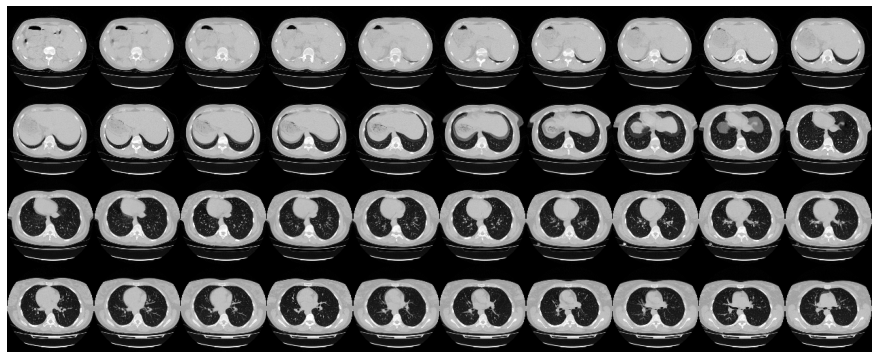

In [5]:
import matplotlib.pyplot as plt

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


example_image = normal_scans[0]
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, example_image[:, :, :40])

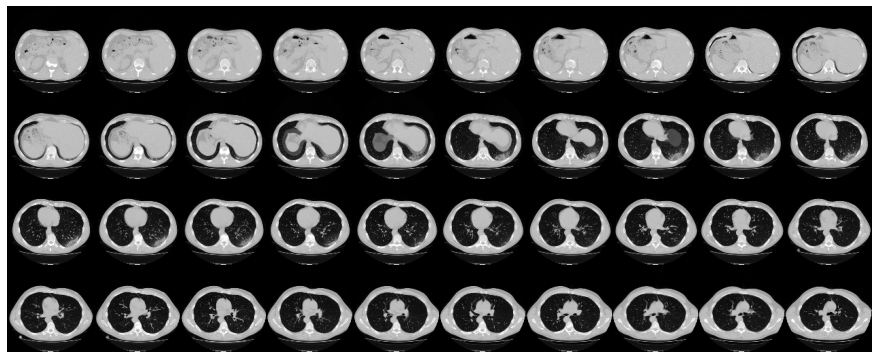

In [6]:
example_image = abnormal_scans[0]
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, example_image[:, :, :40])

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 2
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
)

print('train dataloader', len(train_dataloader))
print('val dataloader', len(val_dataloader))

train dataloader 80
val dataloader 20


In [9]:
from torch import nn
import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool3d(2, padding=1),
            nn.BatchNorm3d(64),
            
            nn.Conv3d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool3d(2, padding=1),
            nn.BatchNorm3d(64),
            
            nn.Conv3d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool3d(2, padding=1),
            nn.BatchNorm3d(128),
            
            nn.Conv3d(128, 256, 3),
            nn.ReLU(),
            nn.MaxPool3d(2, padding=1),
            nn.BatchNorm3d(256),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 1),
        )
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = F.avg_pool3d(x, 3)
        x = self.flatten(x)
        x = self.linear(x)
        logits = self.sig(x)
        return logits



model = Baseline()
example_batch = next(iter(train_dataloader))
print(example_batch[0].shape)
output = model(example_batch[0])
print(output.shape)
print(example_batch[1].shape)

torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 1])
torch.Size([2, 1])


In [28]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR

optimizer = AdamW(model.parameters(), lr=1e-4)
lr_scheduler = ExponentialLR(optimizer, gamma=0.96)

In [29]:
def run_evaluation(device):
    total_correct = 0
    total = 0
    model.eval()
    for (x, y) in val_dataloader:
        x = x.to(device)
        logits = model(x)
        prediction = (logits >= 0.5).type(torch.IntTensor)
        correct = torch.sum(y == prediction)
        total_correct += correct
        total += len(x)
    acc = total_correct / total
    return acc

In [30]:
loss_fn = nn.BCELoss()

def train(device):
    model.train()
    total_loss = 0
    size = len(train_dataloader)
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.type(torch.FloatTensor).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
    L = total_loss / size
    print(f'loss: {total_loss:>7f}')


device = 'cuda'
model.to(device)
num_epochs = 100
for epoch in range(num_epochs):
    train(device)
    
    accuracy = run_evaluation(device)
    print(f'{epoch+1} accuracy', accuracy)

loss: 4.818168
accuracy tensor(0.5750)
loss: 2.596940
accuracy tensor(0.5250)
loss: 2.371434
accuracy tensor(0.5750)
loss: 2.149907
accuracy tensor(0.5250)
loss: 1.786006
accuracy tensor(0.5500)
loss: 0.705199
accuracy tensor(0.5500)
loss: 0.769579
accuracy tensor(0.5500)
loss: 0.638287
accuracy tensor(0.5750)
loss: 0.647050
accuracy tensor(0.6000)
loss: 0.449150
accuracy tensor(0.5750)
loss: 0.275288
accuracy tensor(0.6000)
loss: 0.524592
accuracy tensor(0.6000)
loss: 0.196816
accuracy tensor(0.6250)
loss: 0.404240
accuracy tensor(0.6250)
loss: 0.272588
accuracy tensor(0.6000)
loss: 0.143296
accuracy tensor(0.5750)
loss: 0.101095
accuracy tensor(0.5750)
loss: 0.073918
accuracy tensor(0.5500)
loss: 0.092785
accuracy tensor(0.6000)
loss: 0.126864
accuracy tensor(0.5750)
loss: 0.074011
accuracy tensor(0.5750)
loss: 0.057904
accuracy tensor(0.5750)
loss: 0.048667
accuracy tensor(0.5750)
loss: 0.073319
accuracy tensor(0.5750)
loss: 0.049428
accuracy tensor(0.6000)
loss: 0.945995
accuracy t